In [ ]:
def get_constraint_sign(constraint_type):
    if constraint_type == "lte":
        return "<="
    elif constraint_type == "gte":
        return ">="
    elif constraint_type == "eq":
        return "="
    else:
        return constraint_type

In [ ]:
import json

with open('/content/input (2).json', 'r') as file:
    data = json.load(file)

coefficients = data["f"]
goal = data["goal"]
constraints = data["constraints"]

print("Целевая функция:")
print("f(x) =", " + ".join([f"{coefficients[i]} · x{i + 1}"
                            for i in range(len(coefficients))]), f"→ {goal}")
print("Ограничения:")
for constraint in constraints:
    coefs = constraint["coefs"]
    constraint_type = constraint["type"]
    b = constraint["b"]
    constraint_sign = get_constraint_sign(constraint_type)
    constraint_str = " + ".join([f"{coefs[i]} · x{i + 1}"
     for i in range(len(coefs))])
    print(f"{constraint_str} {constraint_sign} {b}")


Целевая функция:
f(x) = 1 · x1 + 2 · x2 + 3 · x3 → max
Ограничения:
1 · x1 + 0 · x2 + 0 · x3 <= 1
1 · x1 + 1 · x2 + 0 · x3 >= 2
1 · x1 + 1 · x2 + 1 · x3 = 3


### Код

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, message="Alternate solution exists")

In [ ]:
from fractions import Fraction
from warnings import warn

def create_coefficient_matrix_from_constraints(data):
    num_decision_vars = len(data["f"])
    num_slack_vars = len([c for c in data["constraints"] if c["type"] in ['gte', 'lte']])
    num_surplus_vars = len([c for c in data["constraints"] if c["type"] in ['lte', 'eq']])
    total_vars = num_decision_vars + num_slack_vars + num_surplus_vars

    coeff_matrix = [[Fraction(0, 1) for _ in range(total_vars + 1)] for _ in range(len(data["constraints"]) + 1)]
    slack_index = num_decision_vars
    surplus_index = num_decision_vars + num_slack_vars
    surplus_rows = []

    for i, constraint in enumerate(data["constraints"], start=1):
        coefficients, b, constraint_type = constraint["coefs"], constraint["b"], constraint["type"]

        for j, coefficient in enumerate(coefficients):
            coeff_matrix[i][j] = Fraction(coefficient, 1)

        coeff_matrix[i][slack_index] = Fraction(1, 1) if constraint_type == 'lte' else Fraction(-1, 1) if constraint_type == 'gte' else 0
        coeff_matrix[i][surplus_index] = Fraction(1, 1) if constraint_type in ['gte', 'eq'] else 0
        slack_index += 1 if constraint_type == 'lte' or constraint_type == 'gte' else 0
        surplus_index += 1 if constraint_type in ['gte', 'eq'] else 0
        if constraint_type in ['gte', 'eq']:
            surplus_rows.append(i)

        coeff_matrix[i][-1] = Fraction(b, 1)

    return coeff_matrix, surplus_rows, num_slack_vars, num_surplus_vars, num_decision_vars

def phase_one(coeff_matrix, surplus_rows, num_decision_vars, num_slack_vars, num_surplus_vars):
    surplus_index = num_decision_vars + num_slack_vars
    slack_index = num_decision_vars

    coeff_matrix[0][-surplus_index:] = [-Fraction(1, 1)] * surplus_index
    coeff_0 = 0

    for i in surplus_rows:
        coeff_matrix[0] = add_rows(coeff_matrix[0], coeff_matrix[i])
        basic_vars[i] = surplus_index
        surplus_index += 1

    for i in range(1, len(basic_vars)):
        if basic_vars[i] == 0:
            basic_vars[i] = slack_index
            slack_index += 1

    key_column = find_max_coefficient_index(coeff_matrix[0])
    condition = coeff_matrix[0][key_column] > 0

    while condition:
        key_row = find_key_row(coeff_matrix, key_column)
        basic_vars[key_row] = key_column
        pivot = coeff_matrix[key_row][key_column]
        normalize_row(coeff_matrix, key_row, pivot)
        zero_out_key_column(coeff_matrix, key_column, key_row)

        key_column = find_max_coefficient_index(coeff_matrix[0])
        condition = coeff_matrix[0][key_column] > 0

    if coeff_matrix[0][-1] != 0:
        warn("Alternate solution exists")

def find_key_row(coeff_matrix, key_column):
    min_val = float("inf")
    min_i = 0

    for i in range(1, len(coeff_matrix)):
        if coeff_matrix[i][key_column] > 0:
            val = coeff_matrix[i][-1] / coeff_matrix[i][key_column]
            if val < min_val:
                min_val = val
                min_i = i

    if min_val == float("inf"):
        raise ValueError("Unbounded solution")

    if min_val == 0:
        warn("Degeneracy")

    return min_i

def normalize_row(coeff_matrix, key_row, pivot):
    for i in range(len(coeff_matrix[0])):
        coeff_matrix[key_row][i] /= pivot

def zero_out_key_column(coeff_matrix, key_column, key_row):
    num_columns = len(coeff_matrix[0])

    for i in range(len(coeff_matrix)):
        if i != key_row:
            factor = coeff_matrix[i][key_column]
            for j in range(num_columns):
                coeff_matrix[i][j] -= coeff_matrix[key_row][j] * factor

def remove_surplus_vars(coeff_matrix, num_decision_vars, num_slack_vars, num_surplus_vars):
    for i in range(len(coeff_matrix)):
        non_surplus_length = num_decision_vars + num_slack_vars + 1
        length = len(coeff_matrix[i])

        while length != non_surplus_length:
            del coeff_matrix[i][non_surplus_length - 1]
            length -= 1

def update_objective_function(coeff_matrix, objective_function):
    for i in range(len(objective_function)):
        coeff, index = objective_function[i], i + 1
        if objective_function[i - 1] == '-':
            coeff_matrix[0][index - 1] = Fraction(str(coeff) + "/1")
        else:
            coeff_matrix[0][index - 1] = Fraction("-" + str(coeff) + "/1")




def optimize_objective(coeff_matrix, basic_vars, num_decision_vars, maximize):
    update_objective_function(coeff_matrix, data["f"])

    compare_func = (lambda a, b: a < b) if maximize else (lambda a, b: a > b)
    get_key_column_func = find_min_coefficient_index if maximize else find_max_coefficient_index


    for row, column in enumerate(basic_vars[1:]):
        if coeff_matrix[0][column] != 0:
            coeff_matrix[0] = add_rows(coeff_matrix[0], multiply_row_by_constant(-coeff_matrix[0][column], coeff_matrix[row + 1]))

    key_column = get_key_column_func(coeff_matrix[0])
    condition = compare_func(coeff_matrix[0][key_column], 0)

    while condition:
        key_row = find_key_row(coeff_matrix, key_column)
        basic_vars[key_row] = key_column
        pivot = coeff_matrix[key_row][key_column]
        normalize_row(coeff_matrix, key_row, pivot)
        zero_out_key_column(coeff_matrix, key_column, key_row)
        key_column = get_key_column_func(coeff_matrix[0])
        condition = compare_func(coeff_matrix[0][key_column], 0)

    solution = {}
    for i, var in enumerate(basic_vars[1:]):
        if var < num_decision_vars:
            solution[f'x_{var + 1}'] = coeff_matrix[i + 1][-1]

    for i in range(0, num_decision_vars):
        if i not in basic_vars[1:]:
            solution[f'x_{i + 1}'] = Fraction("0/1")

    # for i in range(len(coeff_matrix[0])):
    #   if coeff_matrix[0][i] and i not in basic_vars[1:]:
    #       warn("Alternate Solution exists")
    #        break

    return solution

def add_rows(row1, row2):
    return [x + y for x, y in zip(row1, row2)]

def find_max_coefficient_index(row):
    return max(range(len(row) - 1), key=lambda i: row[i])

def multiply_row_by_constant(constant, row):
    return [constant * x for x in row]

def find_min_coefficient_index(row):
    return min(range(len(row)), key=lambda i: row[i])

In [ ]:
def pretty_print_solution(solution):
    print("Optimal Solution:")
    for variable, value in solution.items():
        print(f"{variable}: {value}")
    print()

In [ ]:
def solution(data):
  try:
    coeff_matrix, surplus_rows, num_slack_vars, num_surplus_vars, num_decision_vars = create_coefficient_matrix_from_constraints(data)
    basic_vars = [0 for _ in range(len(coeff_matrix))]
    phase_one(coeff_matrix, surplus_rows, num_decision_vars, num_slack_vars, num_surplus_vars)
    remove_surplus_vars(coeff_matrix, num_decision_vars, num_slack_vars, num_surplus_vars)
    solution = optimize_objective(coeff_matrix, basic_vars, num_decision_vars, maximize=not ('min' in data["goal"].lower()))
    pretty_print_solution(solution)
    print("Optimal Value:", coeff_matrix[0][-1])
  except:
    print("Function is unbounded. Optimal solution does not exist.")

In [ ]:
import json

json_file_path = "/content/input (2).json"
with open(json_file_path, "r") as json_file:
    data = json.load(json_file)

solution(data)

Optimal Solution:
x_2: 2
x_3: 1
x_1: 0

Optimal Value: 7


### Проверки:

In [ ]:
#examples

data = {
    "f": [2, 3],
    "constraints": [
        {"coefs": [1, -1], "b": 1, "type": "lte"},
        {"coefs": [3, 2], "b": 12, "type": "gte"}
    ],
    "goal": "min"
}

solution(data)

Optimal Solution:
x_1: 9/5
x_2: 0

Optimal Value: 23/5


In [ ]:
data = {
    "f": [1, 2, 3],
    "constraints": [
        {"coefs": [1, 0, 0], "type": "lte", "b": 1},
        {"coefs": [1, 1, 0], "type": "gte", "b": 2},
        {"coefs": [1, 1, 1], "type": "eq", "b": 3}
    ],
    "goal": "min"
}

solution(data)

Optimal Solution:
x_1: 1
x_2: 0
x_3: 0

Optimal Value: 0


In [ ]:
data = {
    "f": [1, 2, 3],
    "constraints": [
        {"coefs": [1, 0, 0], "type": "lte", "b": 1},
        {"coefs": [1, 1, 0], "type": "gte", "b": 2},
        {"coefs": [1, 1, 1], "type": "gte", "b": 3}
    ],
    "goal": "max"
}

solution(data)

Function is unbounded. Optimal solution does not exist.


In [ ]:
data = {
    "f": [1, 5, 3],
    "constraints": [
        {"coefs": [1, 0, 0], "type": "gte", "b": 1},
        {"coefs": [1, 1, 0], "type": "gte", "b": 2},
        {"coefs": [1, 1, 1], "type": "gte", "b": 3}
    ],
    "goal": "max"
}

solution(data)

Function is unbounded. Optimal solution does not exist.


### ВСТРОЕННЫЕ МЕТОДЫ

In [ ]:
pip install pulp matplotlib

Оптимальные значения переменных: [0.0, 2.0, 1.0]
Оптимальное значение функции: 7.0


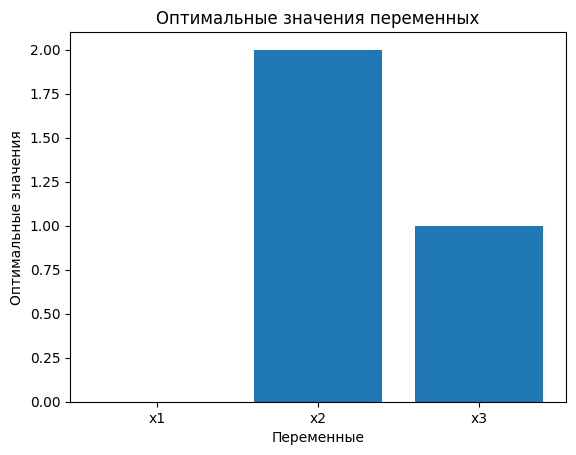

In [ ]:
import pulp
import matplotlib.pyplot as plt
import numpy as np

# Определение задачи с использованием PuLP
coefficients = [1, 2, 3]
goal = pulp.LpMaximize  # Цель - максимизация
lp_problem = pulp.LpProblem("Simplex_Method", goal)

# Определение переменных
x = [pulp.LpVariable(f"x{i}", lowBound=0) for i in range(1, len(coefficients) + 1)]

# Добавление целевой функции
lp_problem += pulp.lpDot(coefficients, x)

# Добавление ограничений
constraints = [
    {"coefs": [1, 0, 0], "type": "lte", "b": 1},
    {"coefs": [1, 1, 0], "type": "gte", "b": 2},
    {"coefs": [1, 1, 1], "type": "eq", "b": 3}
]

for constraint in constraints:
    if constraint["type"] == "lte":
        lp_problem += pulp.lpDot(constraint["coefs"], x) <= constraint["b"]
    elif constraint["type"] == "gte":
        lp_problem += pulp.lpDot(constraint["coefs"], x) >= constraint["b"]
    elif constraint["type"] == "eq":
        lp_problem += pulp.lpDot(constraint["coefs"], x) == constraint["b"]

# Решение задачи
lp_problem.solve()

# Вывод оптимальных значений переменных и значения целевой функции
optimal_values = [pulp.value(var) for var in x]
optimal_value = pulp.value(lp_problem.objective)
print("Оптимальные значения переменных:", optimal_values)
print("Оптимальное значение функции:", optimal_value)

# Создание графиков оптимальных значений переменных
variables = [f"x{i}" for i in range(1, len(coefficients) + 1)]
plt.bar(variables, optimal_values)
plt.xlabel("Переменные")
plt.ylabel("Оптимальные значения")
plt.title("Оптимальные значения переменных")
plt.show()